In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Input
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.layers import BatchNormalization, Conv1D, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam, SGD

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [5]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Actual')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [6]:
dataset = pd.read_csv('data/sample_data.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [7]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
test = dataset[:'2016'].iloc[:,1:2]
training_set.shape

(2768, 1)

In [10]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,training_set.shape[0]):
    X_train.append(training_set[i-60:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(training_set.shape)

(2768, 1)


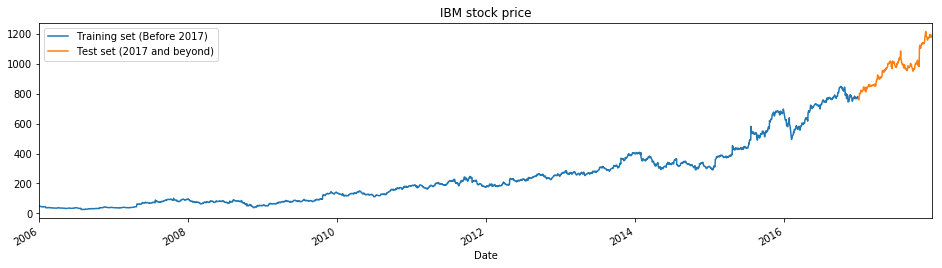

In [5]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [6]:
# Scaling the training set
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [8]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [9]:
def build_attention_model(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, dense_units=128, dr=0.1, use_attention=True):
    max_len = X_train.shape[1]
    inp = Input(shape = (max_len,1))
    x_gru = LSTM(units * 2, return_sequences = True)(inp)
    if use_attention:
        x_att = Attention(max_len)(x_gru)
        x = Dropout(dr)(Dense(dense_units, activation='relu') (x_att))
    else:
        x_att = Flatten() (x_gru)
        x = Dropout(dr)(Dense(dense_units, activation='relu') (x_att))

    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["mean_squared_error"])
    model.summary()
    return model

In [10]:
attention_file_path = "model_checkpoint/best_attention_model.hdf5"
check_point = ModelCheckpoint(attention_file_path, monitor = "val_mean_squared_error", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_mean_squared_error", mode = "min", patience = 3)
attention_model = build_attention_model(lr = 1e-3, lr_d = 1e-7, units = 128, spatial_dr = 0.3, dense_units=25, dr=0.1, use_attention=True)
attention_history = attention_model.fit(X_train, y_train, batch_size = 32, epochs = 50, validation_split=0.1, verbose = 1, callbacks = [check_point, early_stop])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 256)           264192    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               316       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                6425      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
batch_normalization_1

In [11]:
def create_model():
    model = Sequential()
    
    # First laxyer with Dropout regularisation
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    model.add(Dropout(0.2))
    
    # Second layer
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    model.add(Dropout(0.2))
    
    # Third layer
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    model.add(Dropout(0.2))

    # Fourth layer
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer = SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), metrics = ["mean_squared_error"], loss='mean_squared_error')
    return model

In [12]:
file_path = "model_checkpoint/best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 30)
history = create_model().fit(X_train,y_train,epochs=50, batch_size=60, validation_split = 0.3, verbose = 1, callbacks= [check_point])

Train on 1895 samples, validate on 813 samples
Epoch 1/50
1895/1895 [==============================] - 11s 6ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.2364 - val_mean_squared_error: 0.2364

Epoch 00001: val_loss improved from inf to 0.23640, saving model to model_checkpoint/best_model.hdf5
Epoch 2/50
1895/1895 [==============================] - 6s 3ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.2172 - val_mean_squared_error: 0.2172

Epoch 00002: val_loss improved from 0.23640 to 0.21720, saving model to model_checkpoint/best_model.hdf5
Epoch 3/50
1895/1895 [==============================] - 6s 3ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.2184 - val_mean_squared_error: 0.2184

Epoch 00003: val_loss did not improve from 0.21720
Epoch 4/50
1895/1895 [==============================] - 6s 3ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.2155 - val_mean_squared_error: 0.2155

Epoch 00004: val_loss improved from


Epoch 00031: val_loss improved from 0.06720 to 0.06696, saving model to model_checkpoint/best_model.hdf5
Epoch 32/50
1895/1895 [==============================] - 6s 3ms/step - loss: 6.1354e-04 - mean_squared_error: 6.1354e-04 - val_loss: 0.0656 - val_mean_squared_error: 0.0656

Epoch 00032: val_loss improved from 0.06696 to 0.06561, saving model to model_checkpoint/best_model.hdf5
Epoch 33/50
1895/1895 [==============================] - 6s 3ms/step - loss: 6.2682e-04 - mean_squared_error: 6.2682e-04 - val_loss: 0.0652 - val_mean_squared_error: 0.0652

Epoch 00033: val_loss improved from 0.06561 to 0.06524, saving model to model_checkpoint/best_model.hdf5
Epoch 34/50
1895/1895 [==============================] - 6s 3ms/step - loss: 6.1699e-04 - mean_squared_error: 6.1699e-04 - val_loss: 0.0666 - val_mean_squared_error: 0.0666

Epoch 00034: val_loss did not improve from 0.06524
Epoch 35/50
1895/1895 [==============================] - 6s 3ms/step - loss: 6.4817e-04 - mean_squared_error: 6

In [13]:
# Loading Models with Trained Weights of the best model with the lowest validation loss
model = create_model()
model.load_weights(file_path)
attention_model = build_attention_model(lr = 1e-3, lr_d = 1e-7, units = 128, spatial_dr = 0.3, dense_units=25, dr=0.1, use_attention=True)
attention_model.load_weights(attention_file_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 1)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 256)           264192    
_________________________________________________________________
attention_2 (Attention)      (None, 256)               316       
_________________________________________________________________
dense_6 (Dense)              (None, 25)                6425      
_________________________________________________________________
dropout_11 (Dropout)         (None, 25)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 12)                312       
__________

In [14]:
# Generating Sequences using Attention-Based Model
initial_sequence = X_train[X_train.shape[0]-1,:]
attention_sequence = []
for i in range(251):
    new_prediction = attention_model.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    attention_sequence.append(new_prediction)
attention_sequence = sc.inverse_transform(np.array(attention_sequence).reshape(251,1))

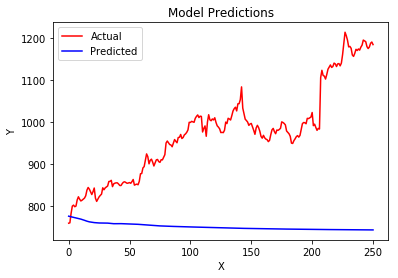

The root mean squared error is 251.64292571714532.


In [15]:
plot_predictions(test_set,attention_sequence)
return_rmse(test_set, attention_sequence)

In [16]:
# Generating Sequences using LSTM Model
initial_sequence = X_train[X_train.shape[0]-1,:]
sequence = []
for i in range(251):
    new_prediction = model.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

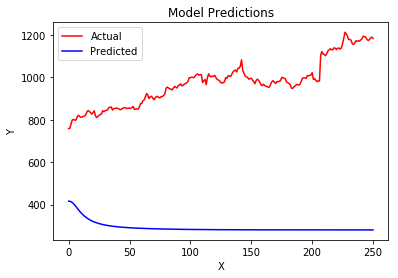

The root mean squared error is 694.7592268167922.


In [17]:
plot_predictions(test_set,sequence)
return_rmse(test_set, sequence)

In [19]:
print(sequence.shape)

(251, 1)
